In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
from typing import Union
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from utils.database.connector import connect_to_database

warnings.filterwarnings('ignore')

## Overview Platforms

In [3]:
def postgres_data(schema_name: str,
                  table_name: str) -> pd.DataFrame:
    with connect_to_database() as connection:
        query = """
            SELECT *
            FROM {schema_name}.{table_name};
        """
        
        df = pd.read_sql_query(
            query.format(schema_name=schema_name, table_name=table_name),
            connection,
            parse_dates=['release_date', 'date_acquired', 'created', 'posted'])
        
        df = df.rename(columns={'game_id': 'gameid',
                                'achievement_id': 'achievementid',
                                'player_id': 'playerid'})

        return df

### Superficial Analysis of the `games` table

In [4]:
from analysis.helper import PLATFORMS, COLORS

# A dictionary where the keys - platform names,
# and the values - DataFrames of the `games` table
games_df = {}
for platform in PLATFORMS:
    games_df[platform] = postgres_data(platform, 'games')

games_df[PLATFORMS[0]].head(3)

,gameid,title,developers,publishers,genres,supported_languages,release_date
0,3281560,Horror Game To Play With Friends! Playtest,None,None,None,None,2024-10-21
1,3280930,Eternals' Path Playtest,None,None,None,None,2024-10-17
2,3280770,ANGST: A TALE OF SURVIVAL - Singleplayer Playtest,None,None,None,None,2024-10-13


Let's preprocess the data:  
* Remove betatests, playtests
* Exclude data without release dates
* Exclude games with multiple release regions

In [5]:
for platform in PLATFORMS:
    games_df[platform].dropna(subset=['release_date'], inplace=True)
    
    games_df[platform] = games_df[platform][~games_df[platform].title.str.endswith('Playtest')]

    if platform != 'playstation':
        # Add a column to avoid catching an Exception
        games_df[platform]['platform'] = platform
    games_df[platform].drop_duplicates(subset=['title', 'platform', 'release_date'], inplace=True)

games_df[PLATFORMS[0]].head(3)

,gameid,title,developers,publishers,genres,supported_languages,release_date,platform
5,3278740,NEURO,[Revolt Games],[Strategy First],[Action],"[English, Russian]",2024-10-11,steam
10,3270850,Keep Your Eyes Open,[Texerikus],[Texerikus],[Indie],[English],2024-10-21,steam
15,3267350,Tiny Shooters,[madilumar],[Thetinyverse],"[Action, Free To Play]",[English],2024-10-19,steam


Total number of games for each platform

In [6]:
for platform in PLATFORMS:
    print(f'{platform.capitalize().replace("s", "S")}: Games = {games_df[platform].shape[0]}')

Steam: Games = 92865
PlayStation: Games = 14666
Xbox: Games = 9937


Analyze the trend of game releases by year for each platform

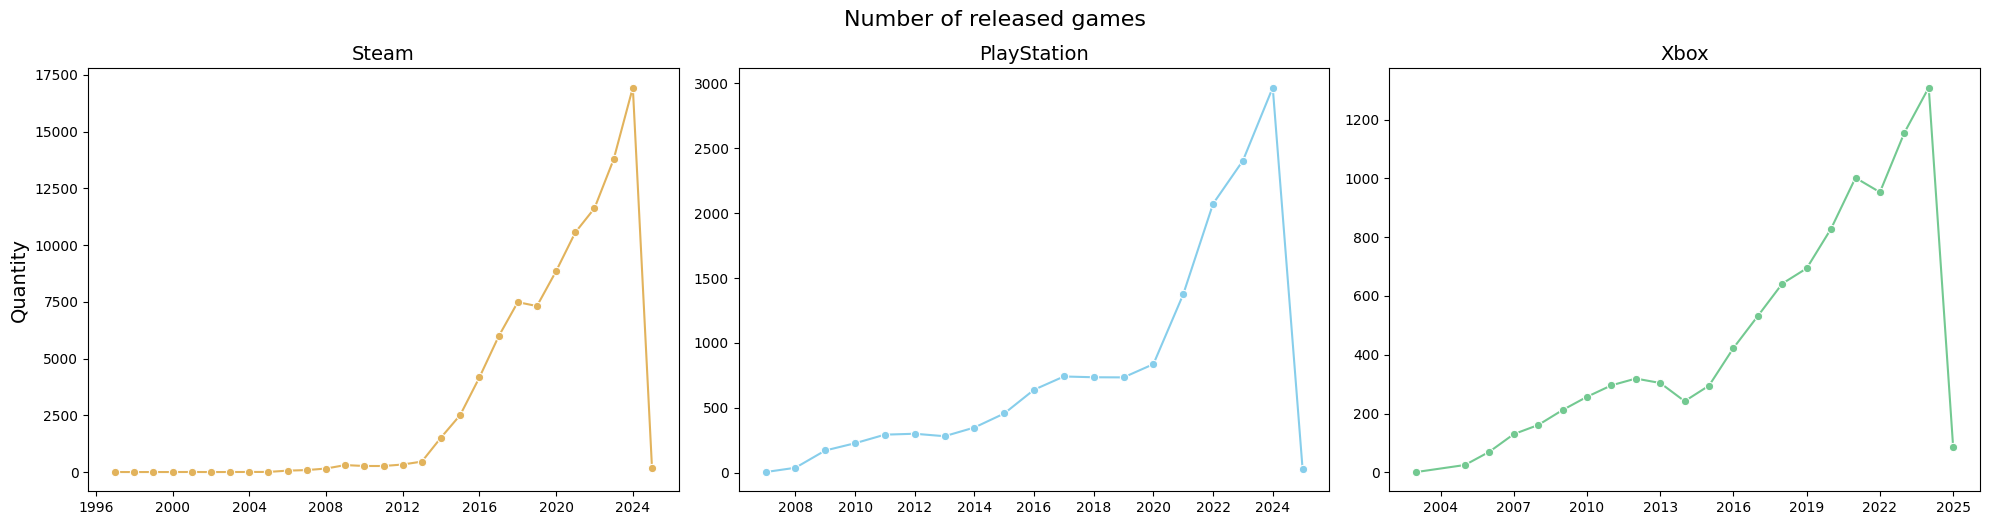

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, color, platform in zip(axes, COLORS, PLATFORMS):
    releases = (
        games_df[platform]
        .release_date.dt.year
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
    )
    
    sns.lineplot(x=releases.release_date, y=releases.quantity,
                 ax=ax, color=color, marker='o')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=14)
    ax.set_xlabel('')

axes[0].set_ylabel('Quantity', fontsize=14)
axes[1].set_ylabel('')
axes[2].set_ylabel('')

fig.text(.5, 1.02, 'Number of released games',
         ha='center', va='center', fontsize=16)

plt.tight_layout()

There is a noticeable increase in the number of games released for each platform  
Steam consistently has the highest number of releases per year compared to its competitors  
This is likely due to **Steam's more developer-friendly policies**, whereas developing for Xbox and PlayStation often requires more resources and effort  

> Let’s verify the hypothesis that a significant portion of games on Steam are indie projects


In [8]:
from analysis.helper import format_genre
from analysis.helper import GENRES

# Refine data preprocessing: standardize genre names
# to a unified format and remove irrelevant categories
all_platforms = pd.DataFrame()
for platform in PLATFORMS:
    genres = games_df[platform].explode('genres')
    
    genres.genres = genres.genres.apply(format_genre)
    genres = genres[genres.genres.isin(GENRES)]

    genres = (
        genres.genres
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'share'})
    )
    
    genres.share = (genres.share / games_df[platform].shape[0] * 100).round(2)

    all_platforms = pd.concat([all_platforms, genres.assign(platform=platform.capitalize())])

pivoted_frequency = (
    all_platforms
    .pivot(index='genres', columns='platform', values='share')
    .fillna(.0)
    .sort_values(['Steam', 'Playstation', 'Xbox'], ascending=False)
)

pivoted_frequency.head(3)

platform,Playstation,Steam,Xbox
genres,,,
Indie,5.61,70.00,6.33
Casual,2.12,42.92,1.83
Action,17.91,41.17,23.49


> **Note:** The genre proportions are independent of each other (the total will not sum to 100%, as a single game can belong to multiple genres)

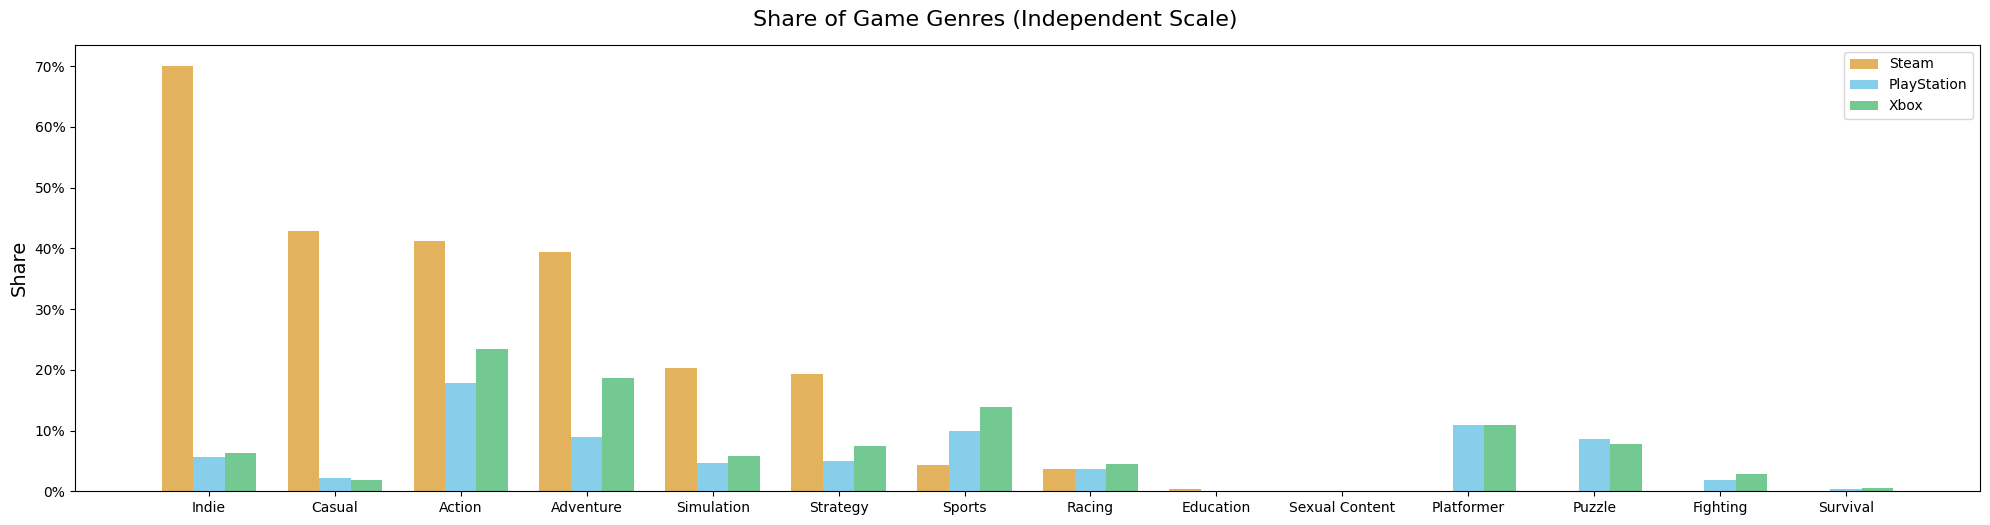

In [9]:
bar_width = .25
x = np.arange(len(pivoted_frequency))

fig, ax = plt.subplots(figsize=(20, 5))
for i, (color, platform) in enumerate(zip(COLORS, PLATFORMS)):
    platform = platform.capitalize()

    ax.bar(x + i * bar_width, pivoted_frequency[platform], bar_width,
           label=platform.replace('s', 'S'), color=color)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(pivoted_frequency.index)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}%'))
ax.set_ylabel('Share', fontsize=14)

ax.legend()

fig.text(.5, 1.02, 'Share of Game Genres (Independent Scale)',
         ha='center', va='center', fontsize=16)

plt.tight_layout()

> Now, let's identify which publishers and developers release games most frequently

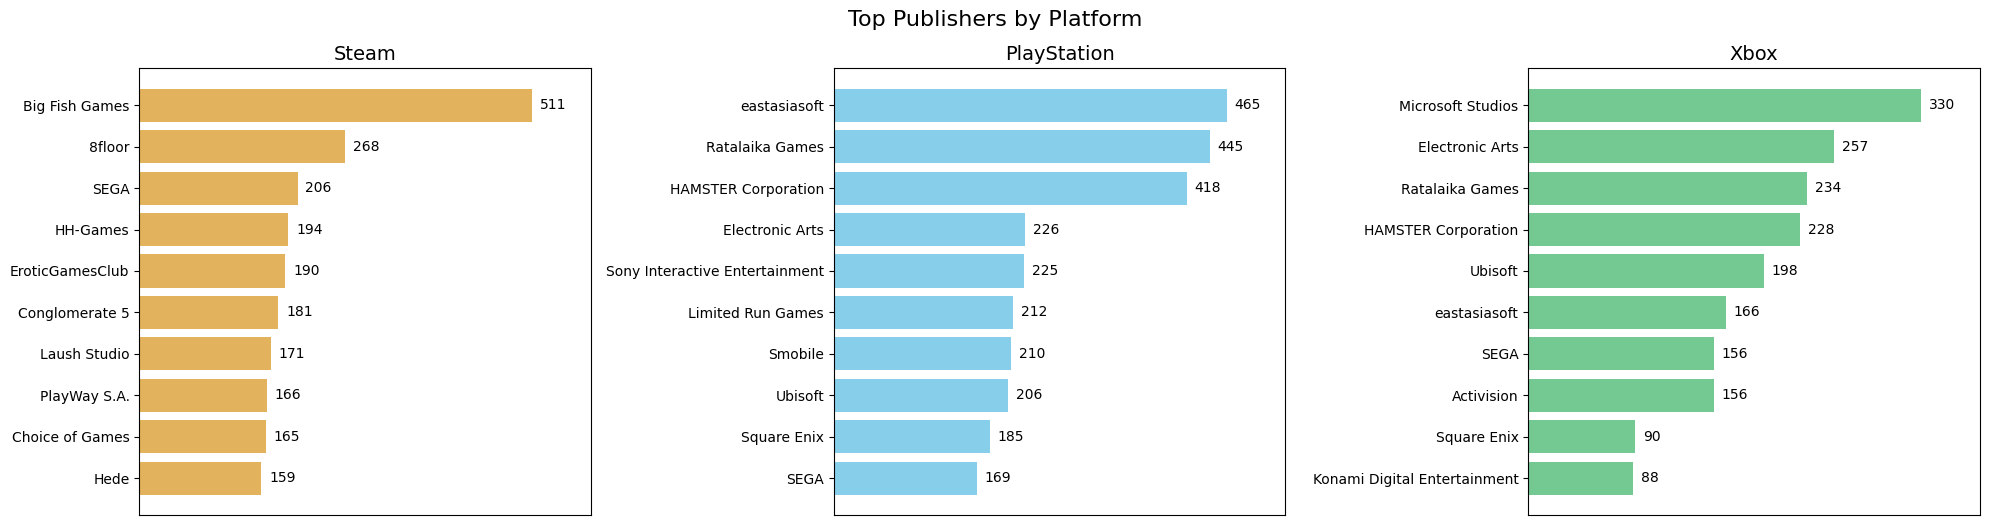

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, platform, color in zip(axes, PLATFORMS, COLORS):
    top_publishers = (
        games_df[platform]
        .explode('publishers')
        .publishers
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
        .head(10)
    )

    bars = ax.barh(top_publishers.publishers, top_publishers.quantity, color=color)

    ax.set_xlim(0, top_publishers.quantity.max() * 1.15)

    for bar, quantity in zip(bars, top_publishers.quantity):
        ax.text(
            bar.get_width() + top_publishers.quantity.max() * .02,
            bar.get_y() + bar.get_height() / 2,
            str(quantity),
            va='center',
            ha='left',
            fontsize=10
        )

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=14)

fig.text(.5, 1.02, 'Top Publishers by Platform',
         ha='center', va='center', fontsize=16)

plt.tight_layout()

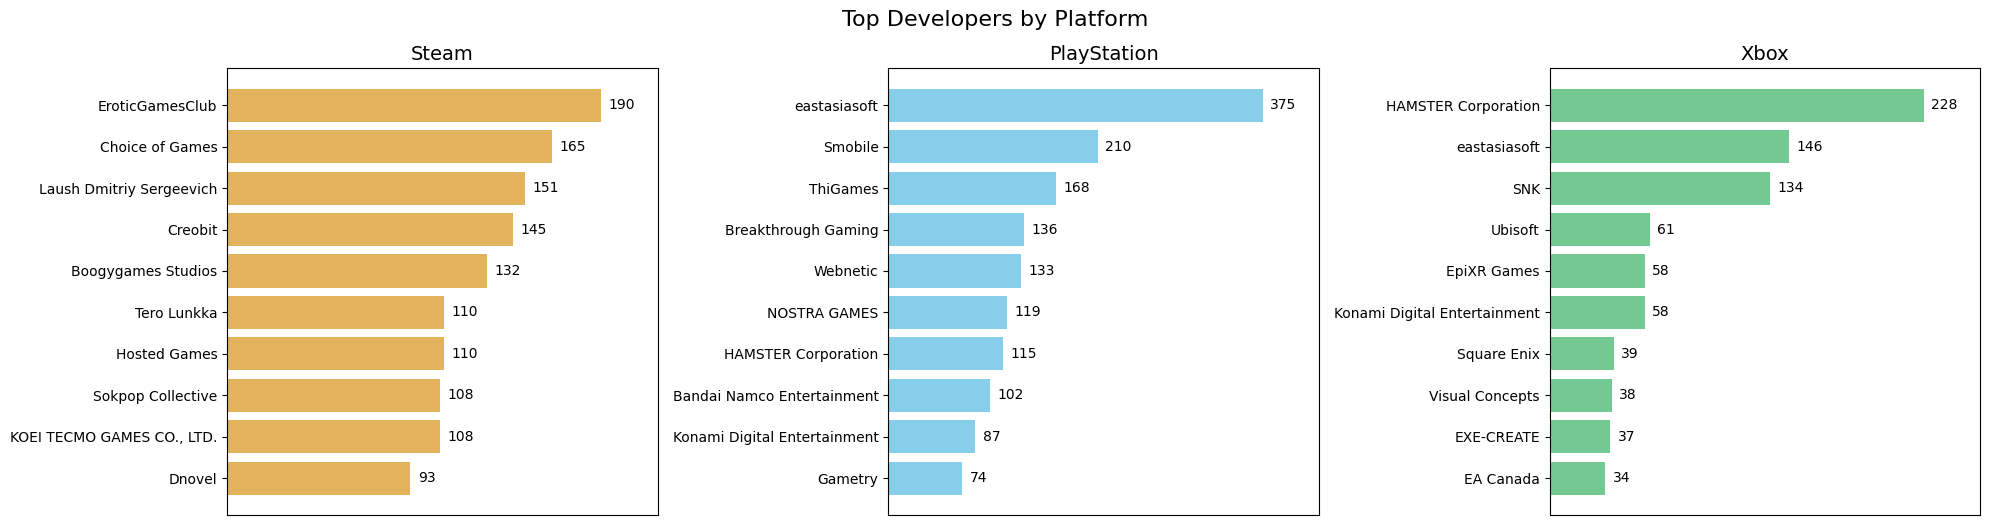

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, platform, color in zip(axes, PLATFORMS, COLORS):
    top_developers = (
        games_df[platform]
        .explode('developers')
        .developers
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
        .head(10)
    )

    bars = ax.barh(top_developers.developers, top_developers.quantity, color=color)

    ax.set_xlim(0, top_developers.quantity.max() * 1.15)

    for bar, quantity in zip(bars, top_developers.quantity):
        ax.text(
            bar.get_width() + top_developers.quantity.max() * .02,
            bar.get_y() + bar.get_height() / 2,
            str(quantity),
            va='center',
            ha='left',
            fontsize=10
        )

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=14)

fig.text(.5, 1.02, 'Top Developers by Platform',
         ha='center', va='center', fontsize=16)

plt.tight_layout()

### Superficial Analysis of the `achievements` table

In [12]:
# A dictionary where the keys - platform names,
# and the values - DataFrames of the `achievements` table
achievements_df = {}

for platform in PLATFORMS:
    achievements_df[platform] = postgres_data(platform, 'achievements')

achievements_df[PLATFORMS[0]].head(3)

,achievementid,gameid,title,description
0,2621440_ACH_FIRST_KILL,2621440,FIRST KILL,You should kill ONE enemy.
1,2621440_ACH_0_LEVEL_COMPLETED,2621440,TUTORIAL COMPLETED,You should complete tutorial.
2,2621440_ACH_1_LEVEL_COMPLETED,2621440,FIRST LEVEL,You should complete first level


Let's examine the distribution of the average number of achievements

Platform policies regarding achievements differ.  
For instance, both PlayStation and Xbox require each game to have at least one achievement,  
while Steam leaves this decision up to the developer. We will address this case

In [13]:
# Let's start by examining the std and mean
for platform in PLATFORMS:
    _filter = ~games_df[platform].gameid.isin(achievements_df[platform].gameid.unique())
    games_without_achievements = games_df[platform][_filter]

    # Addressing the case of Steam (games without achievements)
    games_without_achievements['quantity'] = 0
    games_without_achievements = games_without_achievements[['gameid', 'quantity']]

    frequency_achievements = (
        achievements_df[platform]
        .gameid
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
    )
    
    frequency_achievements = pd.concat([frequency_achievements, games_without_achievements])
    
    mean = frequency_achievements.quantity.mean()
    std = frequency_achievements.quantity.std()

    print(f'{platform.capitalize().replace("s", "S")}: Mean = {mean:.2f}, Std = {std:.2f}')

    # Removing outliers where value > μ + 2σ
    achievements_df[platform] = frequency_achievements.query('quantity <= @mean + 2 * @std')

Steam: Mean = 20.77, Std = 171.03
PlayStation: Mean = 27.56, Std = 17.26
Xbox: Mean = 31.02, Std = 23.43


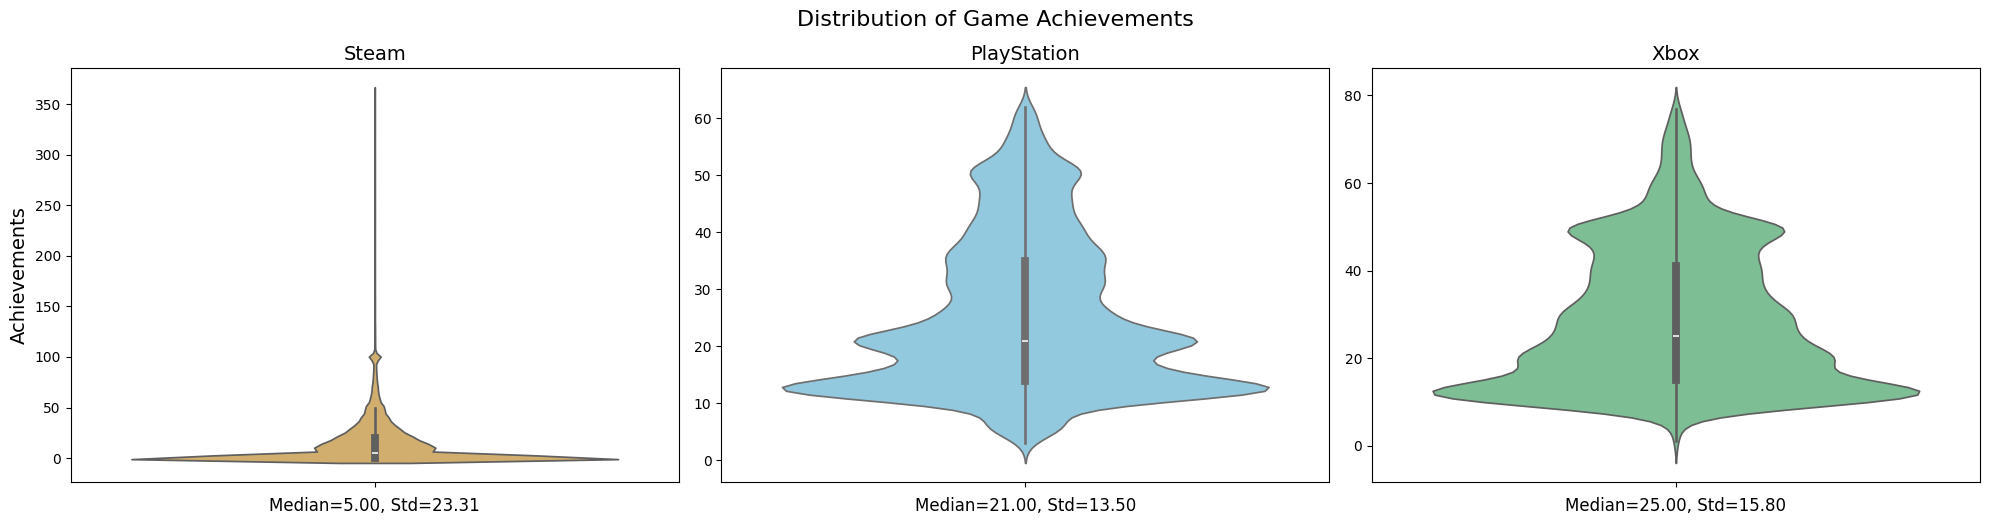

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
for ax, color, platform in zip(axes, COLORS, PLATFORMS):
    sns.violinplot(achievements_df[platform].quantity,
                   ax=ax, color=color)
    
    ax.set_ylabel('')
    ax.set_xlabel(
        f'Median={achievements_df[platform].quantity.median():.2f}, ' \
        f'Std={achievements_df[platform].quantity.std():.2f}',
        fontsize=12
    )
    
    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=14)

axes[0].set_ylabel('Achievements', fontsize=14)

fig.text(.5, 1.02, 'Distribution of Game Achievements',
         ha='center', va='center', fontsize=16)

plt.tight_layout()

> Let's determine which of the samples differ statistically significantly

In [15]:
def bootstrap_ci(data: pd.Series,
                 sample_size: int=10000,
                 ci: int=95) -> Union[np.floating, np.floating, np.floating]:
    boot_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(sample_size)]

    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    
    return np.mean(data), lower, upper

Steam: Mean = 13.92, CI = [13.77, 14.07]
PlayStation: Mean = 25.36, CI = [25.20, 25.51]
Xbox: Mean = 28.69, CI = [28.40, 28.98]


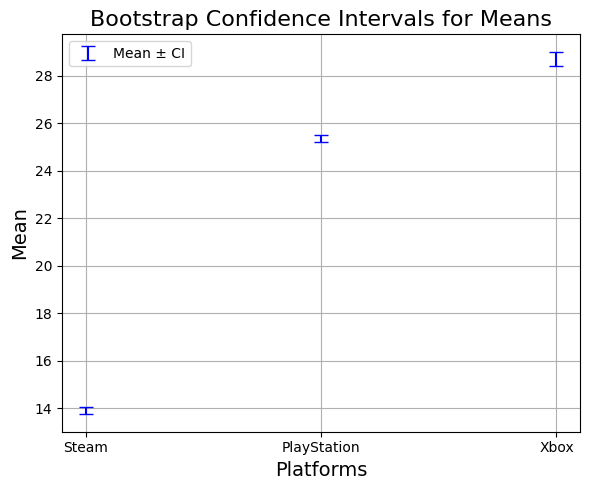

In [16]:
results_bootstrap = {}
for platform in PLATFORMS:
    mean, lower, upper = bootstrap_ci(achievements_df[platform].quantity)
    results_bootstrap[platform.capitalize().replace('s', 'S')] = (mean, lower, upper)

for platform, (mean, lower, upper) in results_bootstrap.items():
    print(f'{platform}: Mean = {mean:.2f}, CI = [{lower:.2f}, {upper:.2f}]')

plt.figure(figsize=(6, 5))

platforms = list(results_bootstrap.keys())
means = [results_bootstrap[platform][0] for platform in platforms]
lowers = [results_bootstrap[platform][1] for platform in platforms]
uppers = [results_bootstrap[platform][2] for platform in platforms]

plt.errorbar(platforms, means, yerr=[np.array(means) - np.array(lowers), np.array(uppers) - np.array(means)], 
             fmt='none', capsize=5, label='Mean ± CI', color='blue')

plt.title('Bootstrap Confidence Intervals for Means', fontsize=16)
plt.ylabel('Mean', fontsize=14)
plt.xlabel('Platforms', fontsize=14)

plt.grid(True)
plt.legend()

plt.tight_layout()

None of the confidence intervals overlap, indicating that the groups are significantly different

### Superficial Analysis of the `players` table

> Let's determine the top countries by the usage of the selected platform

> **Note:** `PlayStation` does not have the `created` feature, and `Xbox` is not considered (data is unavailable)

In [17]:
# A dictionary where the keys - platform names,
# and the values - DataFrames of the `players` table
players_df = {}
for platform in PLATFORMS:
    players_df[platform] = postgres_data(platform, 'players')

players_df[PLATFORMS[0]].head(3)

,playerid,country,created
0,76561198287452552,Brazil,2016-03-02 06:14:20
1,76561198040436563,Israel,2011-04-10 17:10:06
2,76561198049686270,None,2011-09-28 21:43:59


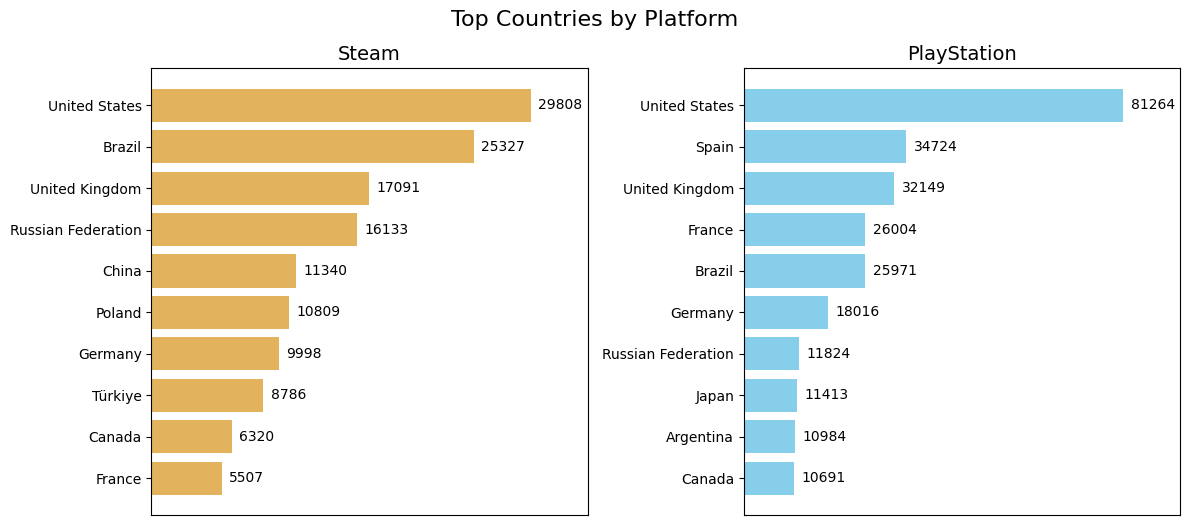

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, color, platform in zip(axes, COLORS[:2], PLATFORMS[:2]):
    top_country = (
        players_df[platform]
        .country
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'peoples'})
        .head(10)
    )

    bars = ax.barh(top_country.country, top_country.peoples, color=color)

    ax.set_xlim(0, top_country.peoples.max() * 1.15)

    for bar, peoples in zip(bars, top_country.peoples):
        ax.text(
            bar.get_width() + top_country.peoples.max() * .02,
            bar.get_y() + bar.get_height() / 2,
            str(peoples),
            va='center',
            ha='left',
            fontsize=10
        )

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=14)

fig.text(.5, 1.02, 'Top Countries by Platform',
         ha='center', va='center', fontsize=16)

plt.tight_layout()